This notebook contains basic info about the best architecture that was found

In [1]:
from urllib.request import urlopen
from PIL import Image
import timm
from transforms import transforming
from train import FrozenNet
import torchinfo
from utils import visualize_transformed_images

img = Image.open(urlopen(
    'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png'
))

model = timm.create_model('efficientnet_b5.sw_in12k', pretrained=True, num_classes = 0)
model = model.eval()

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

data_config

{'input_size': (3, 416, 416),
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'crop_pct': 0.95,
 'crop_mode': 'center'}

In [2]:
transforms

Compose(
    Resize(size=437, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(416, 416))
    MaybeToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

In [3]:
model

EfficientNet(
  (conv_stem): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNormAct2d(
          48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (b

In [4]:
model = FrozenNet()

torchinfo.summary(model, input_size = (1, 3, 416, 416))

Layer (type:depth-idx)                             Output Shape              Param #
FrozenNet                                          [1, 47]                   --
├─EfficientNet: 1-1                                [1, 2048]                 --
│    └─Conv2d: 2-1                                 [1, 48, 208, 208]         (1,296)
│    └─BatchNormAct2d: 2-2                         [1, 48, 208, 208]         96
│    │    └─Identity: 3-1                          [1, 48, 208, 208]         --
│    │    └─SiLU: 3-2                              [1, 48, 208, 208]         --
│    └─Sequential: 2-3                             [1, 512, 13, 13]          --
│    │    └─Sequential: 3-3                        [1, 24, 208, 208]         (5,352)
│    │    └─Sequential: 3-4                        [1, 40, 104, 104]         (122,846)
│    │    └─Sequential: 3-5                        [1, 64, 52, 52]           (329,514)
│    │    └─Sequential: 3-6                        [1, 128, 26, 26]          (1,632,464)
│ 

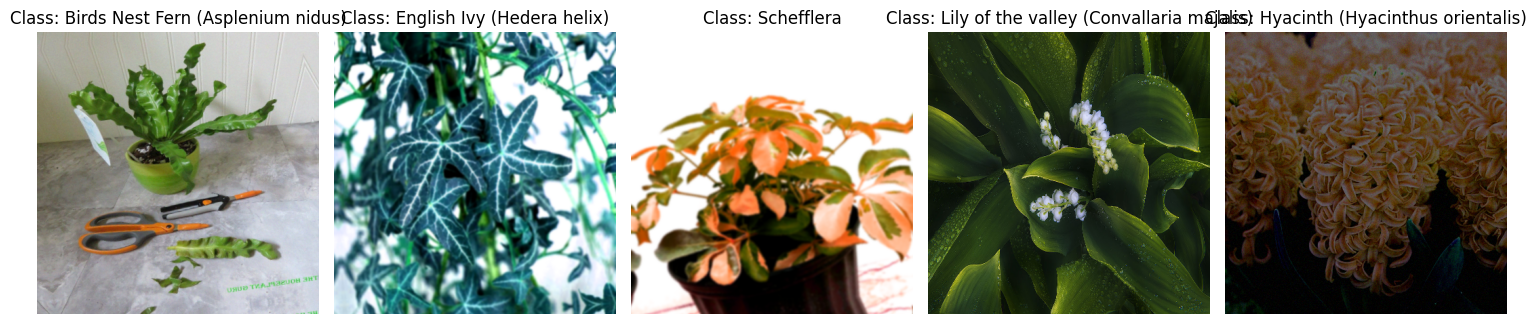

In [5]:
# Aplica transformaciones a los datos
train_data, val_data = transforming(
    selected_transforms=[ "color_jitter", "horizontal_flip", "brightness_contrast", "noise", "blur", "random_rotate"],
    resize_size = 416,
    normalize = False,
    use_float = True,
)

# Visualiza las imágenes transformadas
visualize_transformed_images(train_data, num_images = 5)
